## Setup Env


In [1]:
! pip gym_super_mario_bros --version

ERROR: unknown command "gym_super_mario_bros"



In [2]:
! pip install gym_super_mario_bros==7.3.0 nes_py
# ! pip install lz4


In [3]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT,  RIGHT_ONLY
import gym

In [4]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [5]:
env = gym.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)

c:\Users\manav\miniconda3\envs\ML\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
c:\Users\manav\miniconda3\envs\ML\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [6]:
# Look at observation space
env.observation_space.shape
# essentially the game, frame of the game

(240, 256, 3)

In [7]:
# Action space is alos important
env.action_space

Discrete(7)

In [8]:
done = False
# env.reset()

In [9]:
# done = False
# env.reset()
# while not done:
#     action = env.action_space.sample()
#     _, _, done, _, _ = env.step(action)
#     # done = terminated or truncated

#     # if done:
#     #    env.reset()

# env.close()

In [10]:
import numpy as np
from gym import Wrapper
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack

In [11]:
class SkipFrame(Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self.skip = skip

    def step(self, action):
        total_reward = 0.0
        done = False
        for _ in range(self.skip):
            next_state, reward, done, trunc, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return next_state, total_reward, done, trunc, info

In [12]:
def apply_wrappers(env):
    env = SkipFrame(env, skip=4)
    env = ResizeObservation(env, shape=(128, 128))
    return env

In [13]:
env = apply_wrappers(env)

In [14]:
env.observation_space.shape

(128, 128, 3)

In [15]:
import matplotlib.pyplot as plt

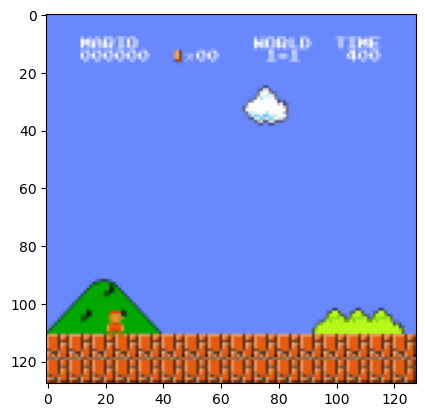

In [16]:
state, _ = env.reset()
env.close()
plt.imshow(state)

In [17]:
import torch
from torch import nn
import numpy as np

In [18]:
class AgentNN(nn.Module):
    def __init__(self, input_shape, n_actions, freeze=False):
        super().__init__()
        self.conv_layers = nn.Sequential(
            # input_shape[0] gives number of in-channels (it is 4 for us)
            nn.Conv2d(input_shape[0], 32, kernel_size=3, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)

        self.network = nn.Sequential(
            self.conv_layers,
            nn.Flatten(),
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

        if freeze:
            self._freeze()

        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.to(self.device)

    def _get_conv_out(self, shape): # to output shape of conv_layers
        o = self.conv_layers(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def _freeze(self):
        for p in self.network.parameters():
            p.requires_grad = False

    def forward(self, x):
        return self.network(x)

In [19]:
# ! pip install tensordict

In [20]:
# ! pip install torchrl

In [1]:
from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

In [22]:
class Agent:
    def __init__(self, input_dims, num_acitons):
        self.num_actions = num_acitons
        self.learning_step_counter = 0

        # Hyper parameters
        self.lr = 0.001
        self.gamma = 0.9 # discount factor
        self.epsilon = 1.0
        self.eps_decay = 0.995
        self.eps_min = 0.1
        self.batch_size = 32
        self.sync_network_rate = 5_000

        # Networks
        self.online_network = AgentNN(input_dims, num_acitons)
        self.target_network = AgentNN(input_dims, num_acitons, freeze=True)

        # Optimizer and loss
        self.optimizer = torch.optim.Adam(self.online_network.parameters(), lr=self.lr)
        self.loss = torch.nn.MSELoss()

        # Replay buffer
        replay_buffer_capacity = 25000
        storage = LazyMemmapStorage(replay_buffer_capacity)
        self.replay_buffer = TensorDictReplayBuffer(storage=storage)

    def choose_action(self, observation):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.num_actions)
        observation = torch.tensor(np.array(observation), dtype=torch.float32).unsqueeze(0).to(self.online_network.device)
        return self.online_network(observation).argmax().item()
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * self.eps_decay, self.eps_min)

    def store_in_memory(self, state, action, reward, next_state, done):
        self.replay_buffer.add(TensorDict({
            "state": torch.tensor(np.array(state), dtype=torch.float32),
            "action": torch.tensor(action),
            "reward": torch.tensor(reward),
            "next_state": torch.tensor(np.array(next_state), dtype=torch.float32),
            "done": torch.tensor(done)
        }, batch_size=[]))


    def sync_networks(self):
        if self.learning_step_counter % self.sync_network_rate == 0 and self.learning_step_counter > 0:
            self.target_network.load_state_dict(self.online_network.state_dict())

    def learn(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        
        self.sync_networks()

        self.optimizer.zero_grad()

        samples = self.replay_buffer.sample(self.batch_size).to(self.online_network.device)

        keys = ("state", "action", "reward", "next_state", "done")

        states, actions, rewards, next_states, dones = [samples[key] for key in keys]

        predicted_q_values = self.online_network(states)
        predicted_q_values = predicted_q_values[np.arange(self.batch_size), actions.squeeze()]

        target_q_values = self.target_network(next_states).max(dim=1)[0]
        target_q_values = rewards*10 + self.gamma * target_q_values * (1 - dones.float())

        loss = self.loss(predicted_q_values, target_q_values)
        loss.backward()
        self.optimizer.step()

        self.learning_step_counter += 1
        self.decay_epsilon()

    def save_agent(self):
        torch.save(self.online_network.state_dict(), "online_model_2.pth")
        torch.save(self.target_network.state_dict(), "target_model_2.pth")


In [23]:
env_t = gym.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
env_t = JoypadSpace(env_t, SIMPLE_MOVEMENT)

c:\Users\manav\miniconda3\envs\ML\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
c:\Users\manav\miniconda3\envs\ML\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [24]:
env_t = apply_wrappers(env_t)

In [25]:
agent = Agent(input_dims=env_t.observation_space.shape, num_acitons=env_t.action_space.n)

In [26]:
# for i in range(50):
#     done = False
#     state, _ = env_t.reset()
#     while not done:
#         action = agent.choose_action(state)
#         if abs(np.random.random()) * 10 <= 2:
#             action = env_t.action_space.sample()
#         new_state, reward, done, truncated, info = env_t.step(action)
#         agent.store_in_memory(state, action, reward, new_state, done)
#         agent.learn()
#         state = new_state
#     print(i)
# agent.save_agent()
# env_t.close()

In [27]:
env_t = gym.make('SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
env_t = JoypadSpace(env_t, SIMPLE_MOVEMENT)

In [28]:
env_t = apply_wrappers(env_t)

In [29]:
model = AgentNN(env_t.observation_space.shape, env_t.action_space.n)  # Initialize the model architecture
model.load_state_dict(torch.load("target_model_2.pth"))  # Load the saved parameters

C:\Users\manav\AppData\Local\Temp\ipykernel_11248\2831317183.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("target_model_2.pth"))  # L

<All keys matched successfully>

In [30]:
replay_buffer_capacity = 25000
storage = LazyMemmapStorage(replay_buffer_capacity)
replay_buffer = TensorDictReplayBuffer(storage=storage)

In [31]:
state, _ = env_t.reset()
for _ in range(50):
    done = False
    state, _ = env_t.reset()
    while not done:
        observation = torch.tensor(np.array(state), dtype=torch.float32).unsqueeze(0).to(model.device)
        action = model(observation).argmax().item()
        if abs(np.random.random()) * 10 <= 2:
                action = env_t.action_space.sample()
        new_state, reward, done, truncated, info = env_t.step(action)
        replay_buffer.add(TensorDict({
                "state": torch.tensor(np.array(state), dtype=torch.int32).squeeze(0),
                "action": torch.tensor(action),
                "next_state": torch.tensor(np.array(state), dtype=torch.int32).squeeze(0),
            }, batch_size=[]))
        state = new_state
env_t.close()

c:\Users\manav\miniconda3\envs\ML\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\manav\miniconda3\envs\ML\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


In [32]:
replay_buffer

TensorDictReplayBuffer(
    storage=LazyMemmapStorage(
        data=TensorDict(
            fields={
                action: MemoryMappedTensor(shape=torch.Size([22406]), device=cpu, dtype=torch.int64, is_shared=False),
                index: MemoryMappedTensor(shape=torch.Size([22406]), device=cpu, dtype=torch.int64, is_shared=False),
                next_state: MemoryMappedTensor(shape=torch.Size([22406, 128, 128, 3]), device=cpu, dtype=torch.int32, is_shared=False),
                state: MemoryMappedTensor(shape=torch.Size([22406, 128, 128, 3]), device=cpu, dtype=torch.int32, is_shared=False)},
            batch_size=torch.Size([22406]),
            device=cpu,
            is_shared=False), 
        shape=torch.Size([22406]), 
        len=22406, 
        max_size=25000), 
    sampler=RandomSampler(), 
    writer=TensorDictRoundRobinWriter(cursor=22406, full_storage=False), 
    batch_size=None, 
    collate_fn=<function _collate_id at 0x000001C592C5BF40>)

In [33]:
path = "buffer.pt"

In [34]:
replay_buffer.dump(path)

In [35]:
rb = TensorDictReplayBuffer(storage=storage)

In [36]:
rb.load(path)

In [37]:
rb

TensorDictReplayBuffer(
    storage=LazyMemmapStorage(
        data=TensorDict(
            fields={
                action: MemoryMappedTensor(shape=torch.Size([22406]), device=cpu, dtype=torch.int64, is_shared=False),
                index: MemoryMappedTensor(shape=torch.Size([22406]), device=cpu, dtype=torch.int64, is_shared=False),
                next_state: MemoryMappedTensor(shape=torch.Size([22406, 128, 128, 3]), device=cpu, dtype=torch.int32, is_shared=False),
                state: MemoryMappedTensor(shape=torch.Size([22406, 128, 128, 3]), device=cpu, dtype=torch.int32, is_shared=False)},
            batch_size=torch.Size([22406]),
            device=cpu,
            is_shared=False), 
        shape=torch.Size([22406]), 
        len=22406, 
        max_size=25000), 
    sampler=RandomSampler(), 
    writer=TensorDictRoundRobinWriter(cursor=22406, full_storage=False), 
    batch_size=None, 
    collate_fn=<function _collate_id at 0x000001C592C5BF40>)